# Transfer Learning with TensorFlow Part 2: Fine-tuning

In the previous notebook, we covered transfer learning feature extraction, now it's time to learn about a new kind of transfer learning: fine-tuning

In [1]:
# Check if we're using a GPU
!nvidia-smi

Sat Sep 30 10:25:35 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

In previous notebooks, we've created a bunch of helper functions, now we could rewrite them all, however, this is tedious.

So, it's a good idea to put functions you'll want to use again in a script you can download and import into your notebooks (or else where).

We've done this for some of the function we've used previously here: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-09-30 10:25:36--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-09-30 10:25:37 (104 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

> 🔑**Note:** If you're running this notebook in Google Colab, when it times out Colab will delete `helper_function.py`, so you'll have to redownload it if you want access to your helper functions.


## Let's get some data

This time we're going to see how we can use the pretrained models within `tf.keras.applications` and applying them to our own problem (recognizing images of food).

In [4]:
# Get 10% of training data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2023-09-30 10:25:40--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.181.207, 64.233.182.207, 64.233.183.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.181.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   124MB/s    in 1.3s    

2023-09-30 10:25:42 (124 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/gri

In [6]:
# Create training and test directories
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [7]:
import tensorflow as tf
IMG_SIZE = (224,224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
train_data_10_percent

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [9]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [10]:
# See an example of a batch of data
for images, labels in train_data_10_percent.take(1):
  print(images,labels)

tf.Tensor(
[[[[2.39183685e+02 2.43183685e+02 2.42183685e+02]
   [2.40642853e+02 2.44642853e+02 2.43642853e+02]
   [2.42428574e+02 2.46428574e+02 2.45428574e+02]
   ...
   [2.45642853e+02 2.49642853e+02 2.48642853e+02]
   [2.46000000e+02 2.50000000e+02 2.49000000e+02]
   [2.46127563e+02 2.50127563e+02 2.49127563e+02]]

  [[2.40239807e+02 2.44239807e+02 2.43239807e+02]
   [2.43857147e+02 2.47857147e+02 2.46857147e+02]
   [2.44142853e+02 2.48142853e+02 2.47142853e+02]
   ...
   [2.44270386e+02 2.48270386e+02 2.47270386e+02]
   [2.44005096e+02 2.48005096e+02 2.47005096e+02]
   [2.43142853e+02 2.47142853e+02 2.46142853e+02]]

  [[2.42071426e+02 2.45642853e+02 2.44642853e+02]
   [2.44158173e+02 2.47729599e+02 2.46729599e+02]
   [2.44260208e+02 2.47831635e+02 2.46831635e+02]
   ...
   [2.47596924e+02 2.51168350e+02 2.50168350e+02]
   [2.47443878e+02 2.51015305e+02 2.50015305e+02]
   [2.47642853e+02 2.51214279e+02 2.50214279e+02]]

  ...

  [[2.44000000e+02 2.55000000e+02 2.51000000e+02]
   [2

## Model 0: Building a transfer learning feature extraction model using the Keras Functional API

The sequential API is straight-forward, it runs our layers in sequential order.

But the functional API gives us more flexibility with our models.

In [11]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying pre-trained patterns aren't updated during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224,224,3),name = "input_layer")

# 4. If using a model like ResNet50V2 you will need to normalize inputs
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10,activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit the model and save its history
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data,
                                 validation_steps=int(0.25*len(test_data)),
                                 callbacks=[create_tensorboard_callback("transfer_leaarning",
                                                                        "10_percent_feature_extraction")])

16705208/16705208 [==============================] - 0s 0us/step
Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_leaarning/10_percent_feature_extraction/20230930-102551
Epoch 1/5
24/24 [==============================] - 23s 279ms/step - loss: 1.9055 - accuracy: 0.4027 - val_loss: 1.3191 - val_accuracy: 0.7072
Epoch 2/5
24/24 [==============================] - 5s 184ms/step - loss: 1.1172 - accuracy: 0.7507 - val_loss: 0.8591 - val_accuracy: 0.8224
Epoch 3/5
24/24 [==============================] - 5s 180ms/step - loss: 0.8001 - accuracy: 0.8160 - val_loss: 0.6618 - val_accuracy: 0.8651
Epoch 4/5
24/24 [==============================] - 4s 143ms/step - loss: 0.6387 - accuracy: 0.8573 - val_loss: 0.5850 - val_accuracy: 0.8651
Epoch 5/5
24/24 [==============================] - 5s 191ms/step - loss: 0.5565 - accuracy: 0.8773 - val_loss: 0.5093 - val_accuracy: 0.8832


In [12]:
# Evaluate on the full dataset
model_0.evaluate(test_data)

79/79 [==============================] - 6s 76ms/step - loss: 0.5601 - accuracy: 0.8564


[0.5600577592849731, 0.8564000129699707]

In [13]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activation
5

In [14]:
# How about we get a summary of the base model?
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, None, None, 3)        0         ['normalization[0

In [15]:
# How about a summary of our whole model?
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062381 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049571 (15.45 MB)
__________________

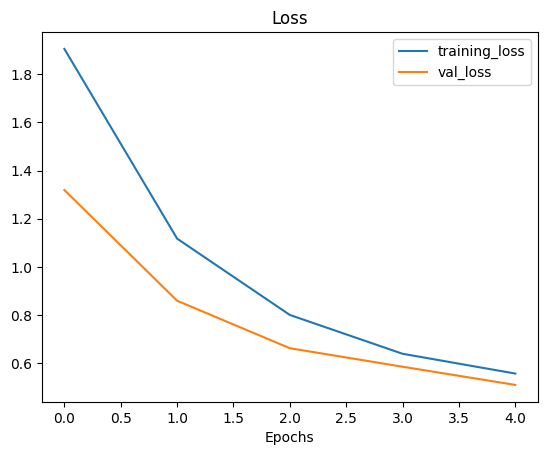

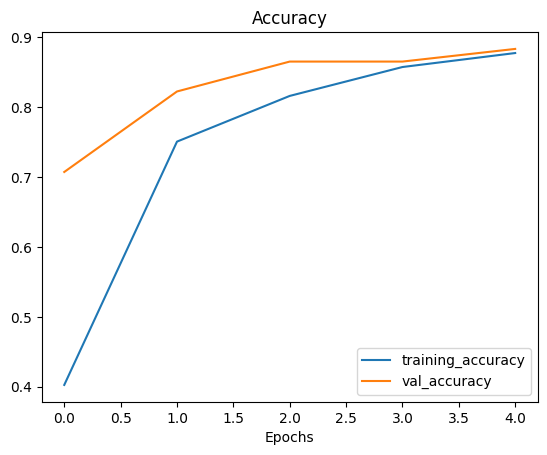

In [16]:
# Check out our model's moss curves
plot_loss_curves(history_10_percent)

## Getting a feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D layer...

We have a tensor after our model goes through `base_model` of shape (None, 7, 7,1280)...

But then when it passes through GlobalAveragePooling2D, it turns into (None, 1280).

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D.


In [17]:
# Define the input shape
input_shape = (1,4,4,3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shape of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of Global Average Pooled 2D tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensor: (1, 3)


In [18]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis = [1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

> 🔑 Note: One of the reasons feature extraction transfer learning is named how it is is because what often happens is a pretrained model outputs a feature vector (a long tensor of numbers, in our case, this is the output of the tf.keras.layers.GlobalAveragePooling2D() layer) which can then be used to extract patterns out of.

## Running a series of transfer learning experiments
We've seen the incredible results transfer learning can get with only 10% of the training data, but how does it go with 1% of the training data...how about we set up a bunch of experiments to find out:

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation
2. `model_2` - use feature extraction transfer learning with 10% of the training with data augmentation
3. `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmentation
4. `model_4` - use fine-tuning transfer learning on 100% of the training data with data augmentation

> 🔑**Note:** Throughout all the experiments the same test dataset will be used to evaluate our model...this ensures consistency across evaluation metrics.

In [19]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2023-09-30 10:26:49--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.1.207, 108.177.120.207, 142.250.103.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.1.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  64.7MB/s    in 2.0s    

2023-09-30 10:26:51 (64.7 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [20]:
# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [21]:
# Walk through 1 percent data directory and list number of files
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'

In [22]:
# Setup data loaders
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           batch_size=32,
                                                                           image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                batch_size=32,
                                                                image_size=IMG_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model


To add data augmentation right into our models, we can use the layers inside:
* `tf.keras.layers.experimental.preprocessing()`

The benefits of using data augmentation inside the model are:
* Preprocessing of images (augmenting them) happens on the GPU (much faster) rather than the CPU
* Image data augmentation only happens during training, so we can still export our whole model and use it elsewhere

In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Create data augmentation stage with horizontal flipping, rotations, zooms, etc
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetV2B0
], name ="data_augmentation")

### Visualize our data augmentation layer (and see what happens to our data)


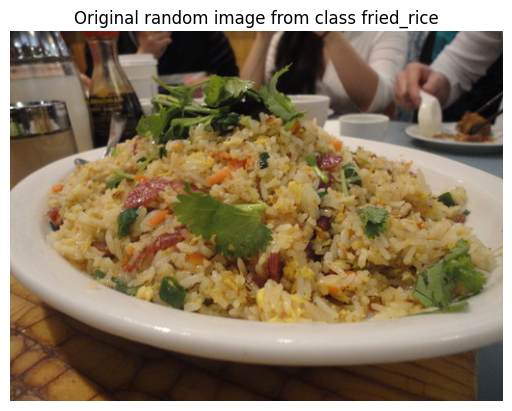

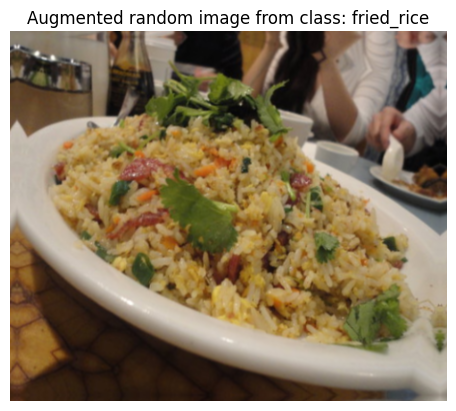

In [24]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class {target_class}")
plt.axis(False)

# Now let's plot our augmented image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0)) # data augmentation model requires shape (None, height, width, 3)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) # requires normalization after augmentation
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [25]:
# Setup input shape and base model, freezing the base model
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model using the inputs and the outputs
model_1 = tf.keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_1_percent),
                        validation_data=test_data,
                        validation_steps=int(0.25*len(test_data)),
                        callbacks=[create_tensorboard_callback("transfer_learning",
                                                               "1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20230930-102657
Epoch 1/5
3/3 [==============================] - 13s 2s/step - loss: 2.4205 - accuracy: 0.0857 - val_loss: 2.2261 - val_accuracy: 0.1957
Epoch 2/5
3/3 [==============================] - 3s 1s/step - loss: 2.1382 - accuracy: 0.1571 - val_loss: 2.0891 - val_accuracy: 0.2845
Epoch 3/5
3/3 [==============================] - 4s 2s/step - loss: 1.9418 - accuracy: 0.3286 - val_loss: 1.9656 - val_accuracy: 0.3618
Epoch 4/5
3/3 [==============================] - 4s 2s/step - loss: 1.7442 - accuracy: 0.4857 - val_loss: 1.8532 - val_accuracy: 0.4342
Epoch 5/5
3/3 [==============================] - 3s 1s/step - loss: 1.5911 - accuracy: 0.5714 - val_loss: 1.7613 - val_accuracy: 0.4852


In [26]:
# Check out the model summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                1281

In [27]:
# Evaluate on the full test dataset
results_1_percent_data_aug = model_1.evaluate(test_data)

79/79 [==============================] - 6s 69ms/step - loss: 1.7646 - accuracy: 0.4856


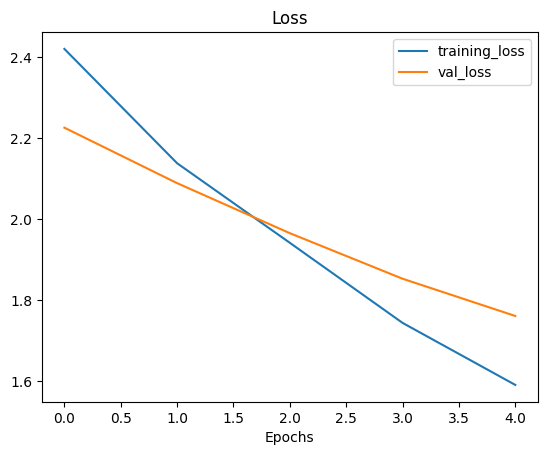

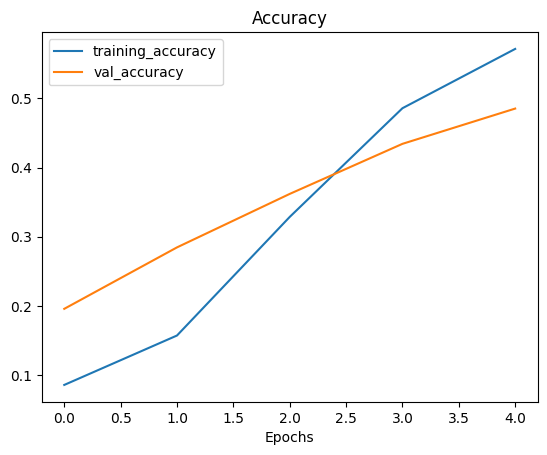

In [28]:
# How do the model with 1% of the data and data augmentation loss curves look?
plot_loss_curves(history_1_percent)

## Model 2: Feature extraction transfer learning model with 10% of data and data augmentation


In [29]:
train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [30]:
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                         label_mode="categorical",
                                                                         batch_size=32,
                                                                         image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                            label_mode="categorical",
                                                            batch_size=32,
                                                            image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [31]:
# Create a functional model with data augmentation
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNet
], name ="data_augmentation")

# Setup the input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base model
# base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# Create input and output layers
inputs = layers.Input(shape=input_shape, name="input_layer") # create input layer
x = data_augmentation(inputs) # augment our training images
x = base_model(x, training=False) # pass augmented images to base model but keep it in inference mode, so batchnorm layers don't get updated: https://keras.io/guides/transfer_learning/#build-a-model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # use Adam optimizer with base learning rate
              metrics=["accuracy"])

24274472/24274472 [==============================] - 0s 0us/step


In [32]:
def create_base_model(input_shape: tuple[int, int, int] = (224, 224, 3),
                      output_shape: int = 10,
                      learning_rate: float = 0.001,
                      training: bool = False) -> tf.keras.Model:
    """
    Create a model based on EfficientNetV2B0 with built-in data augmentation.

    Parameters:
    - input_shape (tuple): Expected shape of input images. Default is (224, 224, 3).
    - output_shape (int): Number of classes for the output layer. Default is 10.
    - learning_rate (float): Learning rate for the Adam optimizer. Default is 0.001.
    - training (bool): Whether the base model is trainable. Default is False.

    Returns:
    - tf.keras.Model: The compiled model with specified input and output settings.
    """

    # Create base model
    base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
    base_model.trainable = training

    # Setup model input and outputs with data augmentation built-in
    inputs = layers.Input(shape=input_shape, name="input_layer")
    x = data_augmentation(inputs)
    x = base_model(x, training=False)  # pass augmented images to base model but keep it in inference mode
    x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
    outputs = layers.Dense(units=output_shape, activation="softmax", name="output_layer")(x)
    model = tf.keras.Model(inputs, outputs)

    # Compile model
    model.compile(loss="categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=["accuracy"])

    return model

# Create an instance of model_2 with our new function
#model_2 = create_base_model()


### Creating a ModelCheckpoint Callback

The ModelCheckpoint callback intermediately saves our model (the full model or just the weigths) during training. This is useful so we can come and start where we left off.

In [33]:
# Setup checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt" # note: remember saving directly to Colab is temporary

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=False, # save only the best model weights instead of a model every epoch
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

### Fit model 2 passing in the ModelCheckPoint callback

In [34]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)), # do less steps per validation (quicker)
                                          callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_data_aug"),
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20230930-102746
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0216 - accuracy: 0.3373
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 32s 979ms/step - loss: 2.0216 - accuracy: 0.3373 - val_loss: 1.5074 - val_accuracy: 0.5855
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3983 - accuracy: 0.6413
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 18s 726ms/step - loss: 1.3983 - accuracy: 0.6413 - val_loss: 1.1169 - val_accuracy: 0.7171
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0973 - accuracy: 0.7427
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 17s 660ms/step - loss: 1.0973 - accuracy: 0.7427 - val_loss: 0.8898 - val_accuracy: 0.7780
E

In [35]:
# What were model_0 results?
model_0.evaluate(test_data)

79/79 [==============================] - 7s 81ms/step - loss: 0.5601 - accuracy: 0.8564


[0.5600579977035522, 0.8564000129699707]

In [36]:
# Evaluate on the test data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 6s 69ms/step - loss: 0.6720 - accuracy: 0.8244


[0.6719895005226135, 0.824400007724762]

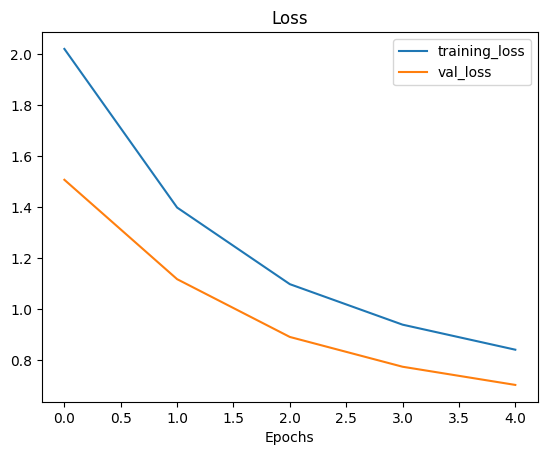

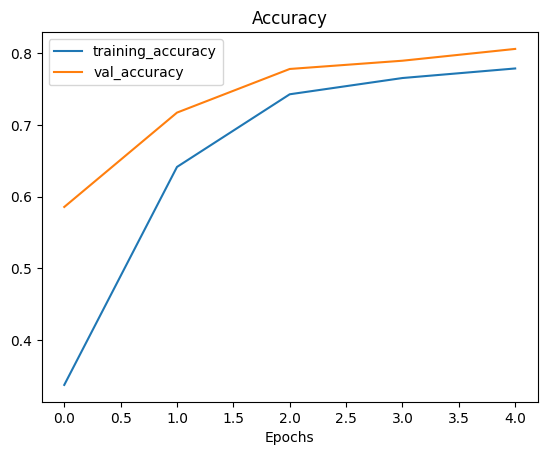

In [37]:
# Plot model loss curves
plot_loss_curves(history_10_percent_data_aug)


### Loading in checkpointed weigths

Loading in checkpointed weights returns a model to a specific checkpoint

In [38]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 6s 75ms/step - loss: 0.6720 - accuracy: 0.8244


In [39]:
# If the results from our native model and the loaded weights are the same, this should output True
results_10_percent_data_aug == loaded_weights_model_results

False

In [40]:
import numpy as np
# Check to see if loaded model results are very close to native model results (should output True)
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))


array([ True,  True])

In [41]:
# Check the difference between the two results (small values)
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))


[-1.1920929e-07  0.0000000e+00]


## Model 3: Fine-tuning an existing model on 10% of the data

> 🔑**Note:** Fine-tuning usually works best **after** training a feature extraction model for a few epochs with large amounts of custom data.

In [42]:
# Layers in loaded model
model_2.layers

In [43]:
# Are these layers trainable?
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x7a6cbd90df30> True
<keras.src.engine.sequential.Sequential object at 0x7a6cbd97e3b0> True
<keras.src.engine.functional.Functional object at 0x7a6cc276cee0> False
<keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7a6cc26cbd60> True
<keras.src.layers.core.dense.Dense object at 0x7a6c985d2200> True


In [44]:
# What layers are in our base model and are they trainable?
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_4 False
2 normalization_2 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [45]:
# How many trainable variables are in our base model?
print(len(model_2.layers[0].trainable_variables))

0


In [46]:
# To begin fine-tuning, let's start by setting the last 10 layers of our base_model.trainable = True
# Make all the layers in model_2_base_model trainable
base_model.trainable = True

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile the whole model (always recompile after any adjustments to a model)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
                metrics=["accuracy"])


> 🔑**Note:** When using fine-tuning it's best practice to lower the learning rate by some amount. How much? This is a hyperparameter you can tune. But a good rule of thumb is atleast 10x (though different sources will claim different values).


In [47]:
# Check which layers are tunable (training)
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_4 False
2 normalization_2 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [48]:
print(len(model_2.trainable_variables))

12


In [49]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs = fine_tune_epochs,
                                               validation_data=test_data,
                                               validation_steps=int(0.25*len(test_data)),
                                               initial_epoch=history_10_percent_data_aug.epoch[-1],
                                               callbacks=[create_tensorboard_callback("transfer_learning",
                                                                                       "10_percent_fine_tune_last_10")]) # start training from previous last epoch

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20230930-102950
Epoch 5/10
24/24 [==============================] - 27s 654ms/step - loss: 0.7189 - accuracy: 0.8067 - val_loss: 0.5968 - val_accuracy: 0.8076
Epoch 6/10
24/24 [==============================] - 14s 559ms/step - loss: 0.6028 - accuracy: 0.8120 - val_loss: 0.5480 - val_accuracy: 0.8092
Epoch 7/10
24/24 [==============================] - 15s 613ms/step - loss: 0.5500 - accuracy: 0.8333 - val_loss: 0.4942 - val_accuracy: 0.8273
Epoch 8/10
24/24 [==============================] - 13s 543ms/step - loss: 0.4875 - accuracy: 0.8427 - val_loss: 0.4907 - val_accuracy: 0.8257
Epoch 9/10
24/24 [==============================] - 14s 583ms/step - loss: 0.4611 - accuracy: 0.8613 - val_loss: 0.5134 - val_accuracy: 0.8273
Epoch 10/10
24/24 [==============================] - 13s 521ms/step - loss: 0.4571 - accuracy: 0.8640 - val_loss: 0.4698 - val_accuracy: 0.8454


In [50]:
# Evaluate tthe fine-tuned model (model_3 which is actually model_2 fine tuned for another 5 epochs)
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 5s 62ms/step - loss: 0.4415 - accuracy: 0.8564


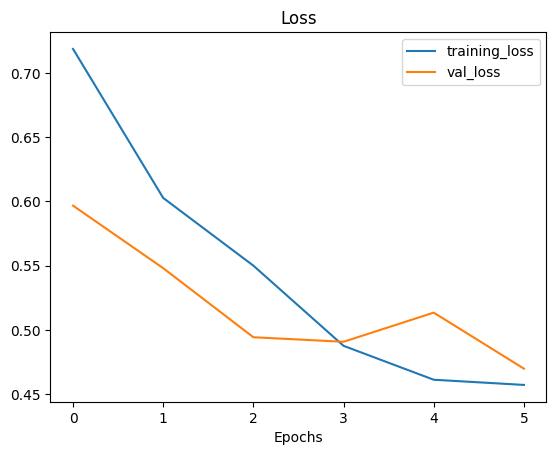

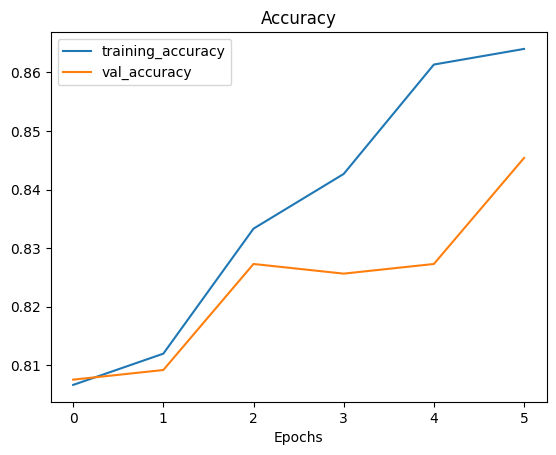

In [51]:
# Check out the loss curves of our fine-tuned model
plot_loss_curves(history_fine_10_percent_data_aug)

The `plot_loss_curves` function works great with models which have only been fit once, however, we want something to compare one series of running `fit()` with another (e.g. before and after fine tune-tuning)

In [52]:
def compare_histories(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()


5
11
[0.3373333215713501, 0.6413333415985107, 0.7426666617393494, 0.765333354473114, 0.7786666750907898, 0.8066666722297668, 0.8119999766349792, 0.8333333134651184, 0.8426666855812073, 0.8613333106040955, 0.8640000224113464]


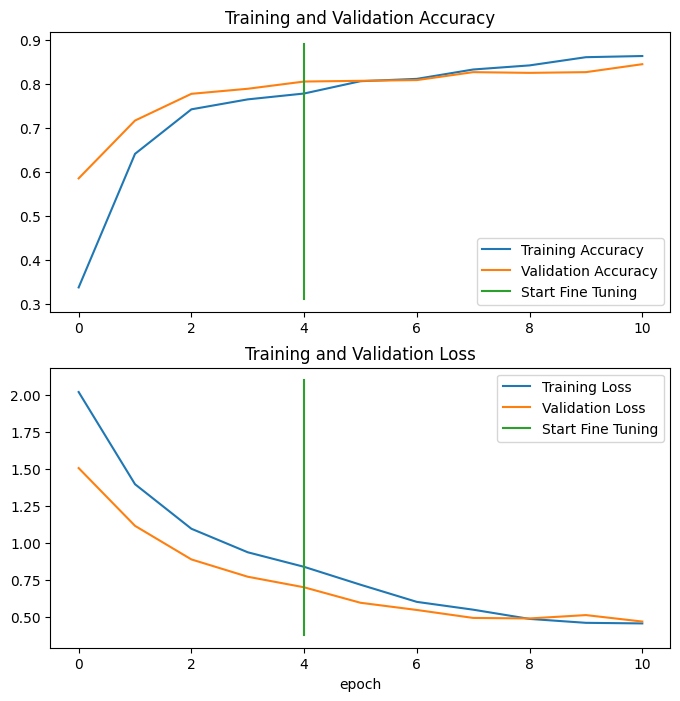

In [53]:

compare_histories(original_history=history_10_percent_data_aug,
                 new_history=history_fine_10_percent_data_aug,
                 initial_epochs=5)

## Model 4: Fine-tuning an existing model on all of the data


In [54]:
# Download and unzip 10 classes of Food101 data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

# Setup data directories
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

--2023-09-30 10:31:41--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.159.207, 142.251.120.207, 142.251.161.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.159.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  72.1MB/s    in 6.5s    

2023-09-30 10:31:48 (75.9 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [55]:
# How many images are we working with now?
walk_through_dir("10_food_classes_all_data")


There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 

In [56]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)

# Note: this is the same test dataset we've been using for the previous modelling experiments
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)


Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The test dataset we've loaded in is the same as what we've been using for previous experiments (all experiments have used the same test dataset).

To train a fine-tuning model (model_4) we need to revert model_2 back to its feature extraction weigths

In [75]:
# Create a new instance of model_2 for experiment 4
model_2= create_base_model(learning_rate=0.0001)

If you are facing any issue during load_weights, then:
1. **Check the Model Architecture**: Make sure that the model architecture you are using to load the weights matches the architecture used when the weights were saved. Any changes in the architecture, such as layer shapes or the number of parameters, can cause this error.

2. **Check the Weight Files**: Ensure that the weight files you are trying to load are the correct ones and have not been modified or corrupted.

3. **Use Compatible Weights**: If you are using pre-trained weights, verify that you are using weights that were trained on a model with the same architecture or a compatible one.

4. **Update Model Code**: If you've made changes to your model's architecture, you may need to update the model loading code to reflect those changes. Make sure the model you are loading the weights into matches the architecture of the model that generated the weights.

5. **Check Layer Names**: Verify that the layer names in the model you are loading the weights into match the layer names in the saved weights. The mismatch in layer names can also lead to this error.

6. **Debugging**: You can print out the shapes of the tensors in both the loaded weights and the model to help identify where the mismatch is occurring.


In [76]:
# Load weights from checkpoints, that way we can fine-tune from the same stage the 10% data model was fine-tuned from
model_2.load_weights(checkpoint_path)

In [77]:
# Let's evaluate model_2 now
model_2.evaluate(test_data)

79/79 [==============================] - 9s 77ms/step - loss: 0.6720 - accuracy: 0.8244


[0.6719894409179688, 0.824400007724762]

In [78]:
# Check if our model_2 has been reverted back to feature extraction results or not
results_10_percent_data_aug

[0.6719895005226135, 0.824400007724762]

In [79]:
print(len(model_2.trainable_variables))


2


What we have done till now

1. Trained a feature extraction transfer learning model for 5 epochs on 10% of the data (with all base model layers frozen) and saved the model's weights using ModelCheckpoint (Model 2).
2. Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen (Model 3).
3. Saved the results and training logs each time.
4. Reloaded the model from 1 to do the same steps as 2 but with all (100%) of the data (Model 4).

In [80]:
# Check which layers are tunable in the whole model
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetv2-b0 False
3 global_average_pooling_layer True
4 output_layer True


In [81]:
# Unfreeze the top 10 layers in model_2's base_model
base_model = model_2.layers[2]
base_model.trainable = True

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

In [82]:
# Let's drill into our base_model (efficientnetb0) and see what layers are trainable

# Check which layers are tuneable in the base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_5 False
1 rescaling_6 False
2 normalization_4 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [83]:
# Recompile the model (always recompile after any adjustments to a model)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
                metrics=["accuracy"])


In [86]:
# Continue to train and fine-tune the model to our data (100% of training data)
fine_tune_epochs = initial_epochs + 5
history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           validation_data=test_data,
                                           validation_steps=int(0.25*len(test_data)),
                                           initial_epoch=history_10_percent_data_aug.epoch[-1],
                                           callbacks=[create_tensorboard_callback("transfer_learning",
                                                                                  "full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20230930-110729
Epoch 5/10
235/235 [==============================] - 94s 357ms/step - loss: 0.7130 - accuracy: 0.7679 - val_loss: 0.3415 - val_accuracy: 0.8799
Epoch 6/10
235/235 [==============================] - 71s 301ms/step - loss: 0.6095 - accuracy: 0.8048 - val_loss: 0.3292 - val_accuracy: 0.8898
Epoch 7/10
235/235 [==============================] - 64s 268ms/step - loss: 0.5479 - accuracy: 0.8273 - val_loss: 0.3185 - val_accuracy: 0.8832
Epoch 8/10
235/235 [==============================] - 58s 241ms/step - loss: 0.5039 - accuracy: 0.8352 - val_loss: 0.3155 - val_accuracy: 0.9046
Epoch 9/10
235/235 [==============================] - 50s 212ms/step - loss: 0.4689 - accuracy: 0.8488 - val_loss: 0.2889 - val_accuracy: 0.9079
Epoch 10/10
235/235 [==============================] - 52s 218ms/step - loss: 0.4530 - accuracy: 0.8525 - val_loss: 0.2889 - val_accuracy: 0.9128


In [87]:
# Let's evaluate on all of the test data
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 6s 71ms/step - loss: 0.2789 - accuracy: 0.9076


[0.27888232469558716, 0.9075999855995178]

5
11
[0.3373333215713501, 0.6413333415985107, 0.7426666617393494, 0.765333354473114, 0.7786666750907898, 0.7678666710853577, 0.8047999739646912, 0.8273333311080933, 0.8352000117301941, 0.848800003528595, 0.8525333404541016]


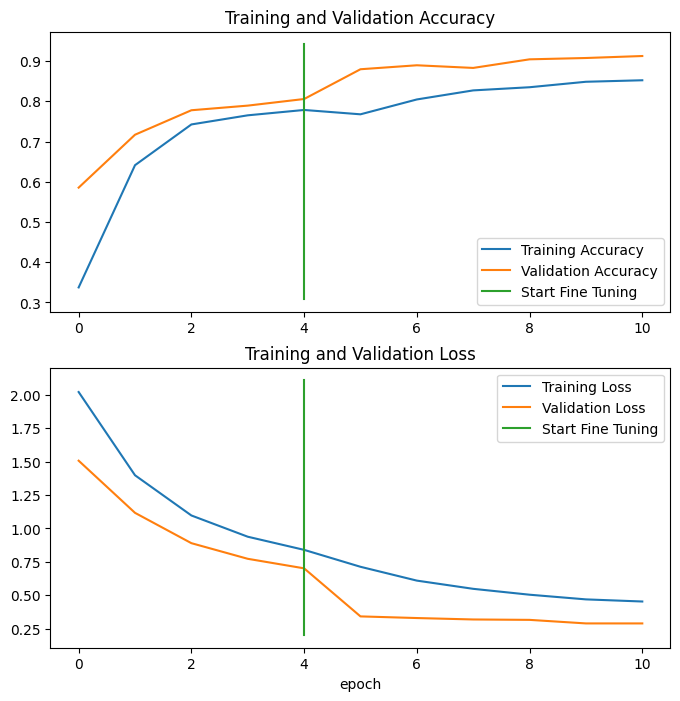

In [88]:
# How did fine-tuning go with more data?
compare_histories(history_10_percent_data_aug,history_fine_10_classes_full,5)

## Viewing our experiment data on TensorBoard

> 🔑**Note:** Remember, whatever you upload to TensorBoard.dev becomes public. If there are training logs you don't want to share, don't upload them.

In [89]:
# View tensorboard logs of transfer learning modelling experiments
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./transfer_learning \
 --name "Transfer Learning Experiments with 10 food101 Classes" \
 --description "A series of different transfer learning experiments with varying amounts of data and fine tuning" \
 --one_shot # exits the uploader once its finished uploading

2023-09-30 11:19:21.921316: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./transfer_learning

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:

   LQBY-PYFY



New experiment created. View your TensorBoard at: https://tensorboard.dev/ex

My TensorBoard experiments are available at: https://tensorboard.dev/experiment/i9Q4phQeTWm225C0o6WYUw/

In [90]:
# View previous experiments
!tensorboard dev list

2023-09-30 11:24:48.562734: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
https://tensorboard.dev/experiment/i9Q4phQeTWm225C0o6WYUw/
	Name                 Transfer Learning Experiments with 10 food101 Classes
	Description          A series of different transfer learning experiments with varying amounts of data and fine tuning
	Id                   i9Q4phQeTWm225C0o6WYUw
	Created              2023-09-30 11:20:12 (4 minutes ago)
	Updated              2023-09-30 11:20:16 (4 minutes ago)
	Runs                 8
	Tags                 5
	Scalars              132
	Tensor bytes         0
	Binary object bytes  4123925
https://tensorboard.dev/experiment/k3YbKibQT26OZrEVP2KpJA/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction model architectures using 10% of the training data
	Id                   k3YbKibQT26OZrEVP2KpJA
	Created              2023-09-27 21:15:43
	Updated    

In [92]:
# Remove previous experiments
# !tensorboard dev delete --experiment_id i9Q4phQeTWm225C0o6WYUw